In [14]:
import os
import cv2
import random
import shutil
import pickle
import numpy as np 
from PIL import Image
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import tensorflow as tf

from keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Input,Flatten,Dense,BatchNormalization,Activation,Dropout,GlobalAveragePooling2D,MaxPooling2D,RandomFlip,RandomZoom,RandomRotation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from lime import lime_image
from skimage.segmentation import mark_boundaries
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install lime

# Dataset Preprocessing

In [5]:
!mkdir /kaggle/working/asldataset
!mkdir /kaggle/working/asldataset/test

In [6]:
# Define the source and destination directories
source_dir = '/kaggle/input/asldataset/dawit'
destination_dir = '/kaggle/working/asldataset/train'

# Copy the directory
shutil.copytree(source_dir, destination_dir)

'/kaggle/working/asldataset/train'

In [8]:
def mover(src_path):
  for alpha in os.listdir("/kaggle/working/asldataset/train"):
    path = src_path+alpha
    destination_path = "/kaggle/working/asldataset/test/"

    for i in range(6):
      # Get a random file from the source path
      file_to_move = random.choice(os.listdir(path))
      # Construct the full path for the file
      source_file_path = os.path.join(path, file_to_move)
      # Construct the destination path for the file
      destination_file_path = os.path.join(destination_path, file_to_move)
      # Move the file
      shutil.move(source_file_path, destination_file_path)
mover("/kaggle/working/asldataset/train/")

In [9]:
!ls /kaggle/working/asldataset/test

A_706.jpeg   E_33.jpeg	  I_234.jpeg   N_451.jpeg   R_875.jpeg	 V_2151.jpeg
A_716.jpeg   E_7.jpeg	  I_242.jpeg   N_456.jpeg   R_880.jpeg	 V_2162.jpeg
A_723.jpeg   E_71.jpeg	  J_1349.jpeg  N_460.jpeg   R_882.jpeg	 W_254.jpeg
A_737.jpeg   E_77.jpeg	  J_1366.jpeg  N_474.jpeg   R_897.jpeg	 W_271.jpeg
A_772.jpeg   F_2050.jpeg  J_1381.jpeg  N_492.jpeg   S_1895.jpeg  W_300.jpeg
A_801.jpeg   F_2075.jpeg  J_1384.jpeg  N_493.jpeg   S_1907.jpeg  W_305.jpeg
B_343.jpeg   F_2081.jpeg  J_1425.jpeg  O_1577.jpeg  S_1921.jpeg  W_308.jpeg
B_363.jpeg   F_2086.jpeg  J_1435.jpeg  O_1601.jpeg  S_1946.jpeg  W_312.jpeg
B_369.jpeg   F_2089.jpeg  K_1806.jpeg  O_1622.jpeg  S_1950.jpeg  X_1707.jpeg
B_395.jpeg   F_2092.jpeg  K_1807.jpeg  O_1625.jpeg  S_1966.jpeg  X_1711.jpeg
B_418.jpeg   G_1988.jpeg  K_1810.jpeg  O_1636.jpeg  T_543.jpeg	 X_1713.jpeg
B_435.jpeg   G_1989.jpeg  K_1830.jpeg  O_1643.jpeg  T_566.jpeg	 X_1721.jpeg
C_1467.jpeg  G_2000.jpeg  K_1841.jpeg  P_2257.jpeg  T_575.jpeg	 X_1725.jpeg
C_1473.jpeg  G_20

In [11]:
x_train = []
y_train = []

x_test = []
y_test = []

In [12]:
path = "/kaggle/working/asldataset/train/"

for alpha in os.listdir(path):
  count = 0
  imgs = os.listdir(path+alpha)
  random.shuffle(imgs)
  for img in imgs:
    image = Image.open(path+alpha+"/"+img)
    image = image.convert('RGB')
    rgb_matrix = np.array(image)
    x_train.append(rgb_matrix)
    y_train.append(alpha)
    count+=1
x_train = np.array(x_train)
y_train = np.array(y_train)

In [13]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_train)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

print("Original labels:", y_train)
print("Integer encoded:", integer_encoded.ravel())
print("One-hot encoded:\n", onehot_encoded)

y_train = onehot_encoded
print(x_train.shape, y_train.shape)

Original labels: ['E' 'E' 'E' ... 'X' 'X' 'X']
Integer encoded: [ 4  4  4 ... 23 23 23]
One-hot encoded:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
(2168, 400, 400, 3) (2168, 26)


In [16]:
path = "/kaggle/working/asldataset/test/"

for item in os.listdir(path):
  alpha = item[0]
  image = Image.open(path+item)
  image = image.convert('RGB')
  rgb_matrix = np.array(image)
  x_test.append(rgb_matrix)
  y_test.append(alpha)

x_test = np.array(x_test)
y_test = np.array(y_test)

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_test)

# Step 2: One-hot encoding
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

print("Original labels:", y_train)
print("Integer encoded:", integer_encoded.ravel())
print("One-hot encoded:\n", onehot_encoded)

y_test = onehot_encoded
print(x_test.shape, y_test.shape)


Original labels: [[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Integer encoded: [ 2  0 20  7 23 24  4  3 18 21  5 18  8 12  9 20  3  5  0 15 15 12 14  6
  6 13  2  3  9 25 15  3 14 24 19 19  5 11 10 17  9  0 12  0 25  1  0 24
 19 16 14 23  8  1  6 19 16  4 25  4  8 18  9 22  7  0  0 23  8 23 14 12
 12 14 25 11 12 11  8  4  4  4 17  1 15 19  8  5 21  7  3 10 24  5  3 13
 15 24 18 14  7 25 22 18 22 11 13  6  2 11 15 18 23  3 20  3  5 16  1 22
  3 13 16 16  7  8 11 13  4 23  0 10 20 19 16 10  9 17  6  9  6  8 20  9
 18 10  7 25 18  2 24 16  9 21  4  5 16 13  7 20 10 21  2 17 14 19  7  4
 20 24 11 19 19 17 15  5 24 14  7  0  7  1 23  4 25  3 22  2 25 12 25  2
 23 15  1 24 13 21 23 17 22 25 21  6  5 24 22 23  2  1 15  5 17 17 13  7
 14 18 12 24 21  2 12 15  2  6 18  9 11 12  3  1 12 24  7 20  1 13 22  9
  8 10 17 19  2  1 14 21 21  2 11 23 10  0 10  8 17 20 13 14 17 19  6  3
 20 16 

# Modelling

In [18]:
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(224,224,3), classes=y_train.shape[1])
base_model.trainable = False
input_dim = (224,224,3)

inputs = tf.keras.Input(shape=(400, 400, 3))
x = tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (224,224)), output_shape=input_dim)(inputs)
x = tf.keras.applications.inception_v3.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(26, activation=('softmax'))(x)
model = tf.keras.Model(inputs, outputs)
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_filepath = '/kaggle/working/best_model.keras'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=False
)

history = model.fit(x_train, y_train, epochs=10, verbose=1,     callbacks=[checkpoint_callback]
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 400, 400, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │        53,274 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,856,058 (83.37 MB)

 Trainable params: 53,274 (208.10 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/10
 2/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.0859 - loss: 3.5433  

W0000 00:00:1716415529.934941     223 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.4073 - loss: 2.2716

W0000 00:00:1716415539.236147     225 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 164ms/step - accuracy: 0.4114 - loss: 2.2569
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.9651 - loss: 0.2441
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.9893 - loss: 0.1003
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.9961 - loss: 0.0585
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.9996 - loss: 0.0371
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.9976 - loss: 0.0297
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.9997 - loss: 0.0234
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.9984 - loss: 0.0203
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 1.0000 - loss: 0.0138
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 1.0000 - loss: 0.0117


In [47]:
!ls /kaggle/working/kaggle/working

# Evaluation

10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


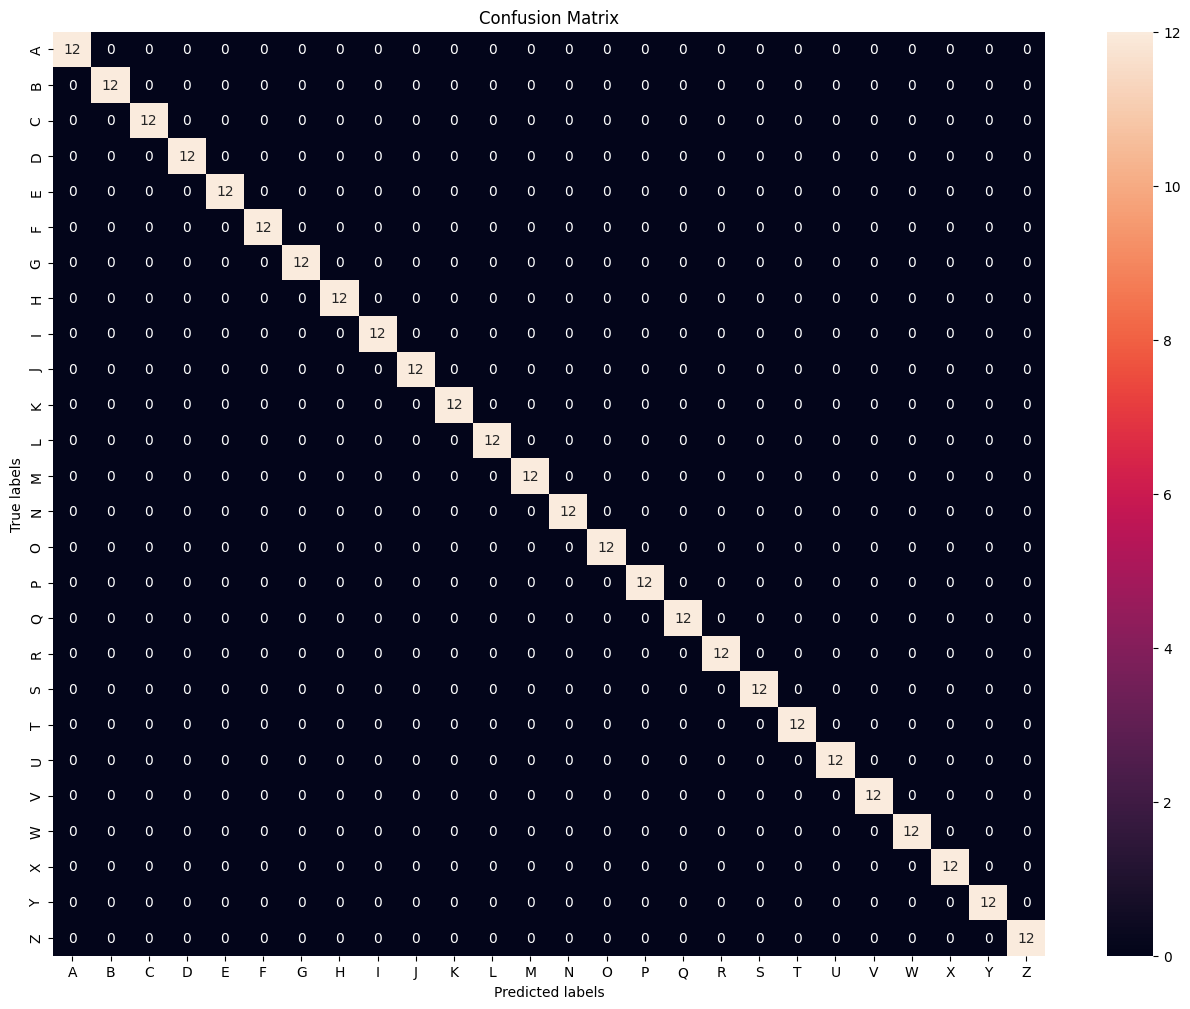

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00        12
           4       1.00      1.00      1.00        12
           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00        12
           7       1.00      1.00      1.00        12
           8       1.00      1.00      1.00        12
           9       1.00      1.00      1.00        12
          10       1.00      1.00      1.00        12
          11       1.00      1.00      1.00        12
          12       1.00      1.00      1.00        12
          13       1.00      1.00      1.00        12
          14       1.00      1.00      1.00        12
          15       1.00      1.00      1.00        12
          16       1.00      1.00      1.00        12
          17       1.00    

In [20]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1_score = f1_score(y_true, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(16, 12))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)  # Annotate cells with values
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'])
ax.yaxis.set_ticklabels(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'])
plt.show()

print(classification_report(y_true, y_pred))

# Interpretation using LIME

In [36]:
classname = "F"
testpath = "/kaggle/working/asldataset/test/"
sampleSet = []
for alpha in os.listdir(testpath):
    if alpha[0] == classname:
        image = Image.open(path+alpha)
        image = image.convert('RGB')
        rgb_matrix = np.array(image)
        sampleSet.append(rgb_matrix)

sampleSet = np.array(sampleSet)
print(sampleSet.shape)

(12, 400, 400, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

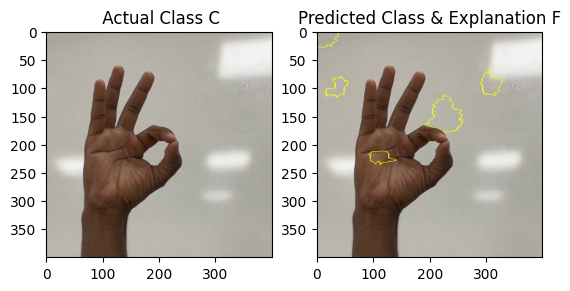

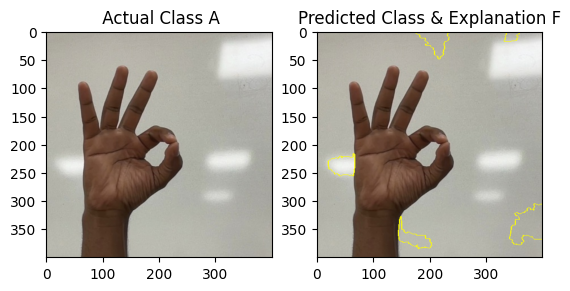

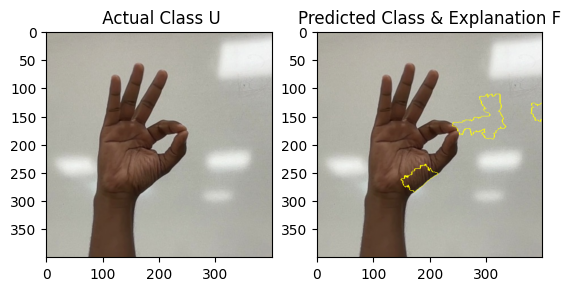

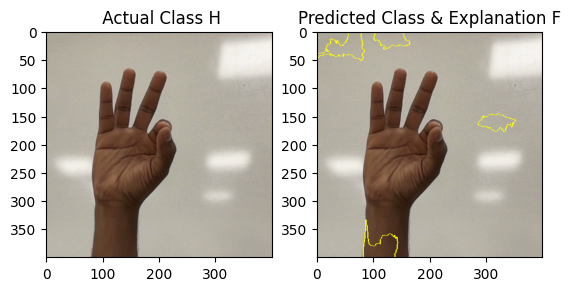

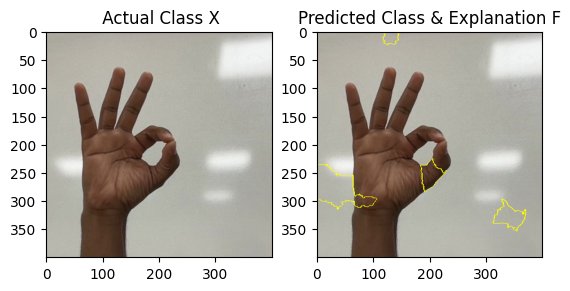

In [37]:
# prompt: for loop to create a plot containing 2 images in one row for a total of 5 rows. I want to add a label for each row
import tensorflow as tf
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import numpy as np
import logging
logging.getLogger('lime').setLevel(logging.ERROR)
logging.getLogger('tensorflow').setLevel(logging.ERROR)
masks = []
temps = []
preds = []
alpha2bin = {i: chr(65+i) for i in range(26)}
explainer = lime_image.LimeImageExplainer()

x_test = sampleSet
for i in range(5):
    explanation = explainer.explain_instance(x_test[i], model.predict,  top_labels=5, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    masks.append(mask)
    temps.append(temp)
    sample = np.array([x_test[i]])
    pred = model.predict(sample)
    predicted_integer_label = np.argmax(pred, axis=1)
    pred_letter = alpha2bin[predicted_integer_label[0]]
    preds.append(pred_letter)

for i in range(5):
    plt.subplot(1, 2, 1)
    plt.imshow(x_test[i])
    letter = alpha2bin[np.argmax(y_test[i])]
    plt.title(f" Actual Class "+letter)
    plt.subplot(1, 2, 2)
    plt.imshow(mark_boundaries(temps[i] / 255, masks[i]))
    plt.title(f"Predicted Class & Explanation "+preds[i])
    plt.show()